# Modelos Machine Learning Bullying a partir de Encuesta Mundial de Salud Escolar

### Grupo 9
Integrantes:
- Cruz, Ruth
- Gabis Leccesi, Luciana
- Palma, Malena Agustina
- Stachoni, Yanina

**Dataset seleccionado:**
- Resultados encuesta EMSE
- Origen de datos: https://datos.gob.ar/ar/dataset/salud-base-datos-3deg-encuesta-mundial-salud-escolar-emse-con-resultados-nacionales-argentina


**Introducción:**

La Encuesta Mundial de Salud Escolar (EMSE) utiliza una metodología estandarizada a nivel mundial para relevar datos sobre aspectos sociodemográficos e indaga sobre conductas relacionadas con el comportamiento alimentario, el consumo de alcohol y otras drogas, la violencia y daños no intencionados, la seguridad vial, la salud mental, el consumo de tabaco, la actividad física, los comportamientos sexuales y los factores de protección.


**Objetivo:**
- Segmentar a los estudiantes en grupos basados en características similares, como hábitos alimenticios, actividad física, consumo de sustancias, y salud mental. Esto permitiría a los responsables de políticas diseñar intervenciones más específicas y dirigidas a cada grupo identificado.

In [ ]:
#Librerias necesarias
import pandas as pd
import numpy as np

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Tratamiento de nulos y variables categóricas
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

#Escalado de variables
from sklearn.preprocessing import StandardScaler

#Algoritmos no supervisados
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

## Análisis de datos

In [ ]:
## Enlaces de google drive correspondientes al dataset y archivo de configuración
url_EMSE_completo= "https://docs.google.com/spreadsheets/d/1FdiRKlv-fCRqXQPveYltvroQenNciBPs0SJfCiYBDdM/gviz/tq?tqx=out:csv&sheet=EMSE_DatosAbiertos"
url_diccionario_dataset = "https://docs.google.com/spreadsheets/d/1CFpI6IWEcJcsPkfJYY6FrIBDuphCyB8i/gviz/tq?tqx=out:csv&sheet=Diccionario"

## Para cargar los archivos local descomentar las siguientes lineas
#url_EMSE_completo = "EMSE_DatosAbiertos.csv"
#url_diccionario_dataset = "Analisis Preguntas.xlsx"

Para este objetivo consideramos que todas las columnas pueden ser de interés por lo que trabajaremos con el dataset completo.

In [ ]:
#Leer Excel creado con la configuración de columnas
df_conf = pd.read_csv(url_diccionario_dataset)
#Si es local, usar la siguiente linea
# df_conf = pd.read_excel(url_diccionario_dataset)
#Obtener nombres de columnas del dataset
columnas_nombres = df_conf["Nombre Columna"].values

In [ ]:
#Leer el csv con los datos ya procesados en la entrega anterior
df = pd.read_csv(url_EMSE_completo)
df.columns = columnas_nombres
#Mostrar algunos datos
df.sample(3)

,edad,sexo,grado,altura,peso,hambre,comida_rapida,recibir_ataque_fisico,participar_pelea,cantidad_lesiones,...,no_venta_alcohol,amigos_alcohol,publicidad_alcohol,veces_extasis,veces_embarazo,sentir_ridiculo,padres_expectativas_altas,bajo_peso,sobre_peso,obeso
51376,13 años,Femenino,8vo grado nivel Primario/Polimodal o 1er año ...,NaN,NaN,Nunca,0 días,Ninguna,Ninguna,Ninguna,...,No intenté comprar alcohol en los últimos 30 días,Definitivamente no,Rara vez,0 veces,0 veces,Siempre,Nunca,Dato perdido,Dato perdido,Dato perdido
41774,17 años,Masculino,2do año/11vo grado nivel Polimodal o 4to año n...,NaN,NaN,Rara vez,Dato perdido,12 o más veces,2 o 3 veces,2 o 3 veces,...,"Sí, hubo alguien que se negó a venderme alcoho...",Probablemente no,Dato perdido,Dato perdido,No lo sé,Siempre,Algunas veces,Dato perdido,Dato perdido,Dato perdido
16459,14 años,Masculino,9no grado nivel Primario/Polimodal o 2do año n...,1.75,49.0,Nunca,3 días,1 vez,2 o 3 veces,1 vez,...,No intenté comprar alcohol en los últimos 30 días,Definitivamente sí,Rara vez,0 veces,0 veces,Siempre,Rara vez,No,No,No


### Tratamiento de nulos y ouliers

Como ya conocemos algunas características de este dataset, procederemos a tratar nulos, outliers y variables categóricas sin mucho más análisis.

In [ ]:
#Remplazar "Dato perdido" por nan
df.replace("Dato perdido", np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56981 entries, 0 to 56980
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad                          56873 non-null  object 
 1   sexo                          56445 non-null  object 
 2   grado                         55920 non-null  object 
 3   altura                        36052 non-null  float64
 4   peso                          36052 non-null  float64
 5   hambre                        56482 non-null  object 
 6   comida_rapida                 56771 non-null  object 
 7   recibir_ataque_fisico         56741 non-null  object 
 8   participar_pelea              56713 non-null  object 
 9   cantidad_lesiones             51559 non-null  object 
 10  tipo_lesion                   52782 non-null  object 
 11  causa_lesion                  51790 non-null  object 
 12  sentir_soledad                56615 non-null  object 
 13  s

In [ ]:
#Eliminar outliers peso
q1, q3 = df["peso"].quantile([.25, .75])
ric = q3 - q1 #rango inter quartil
l_inf = q1 - 1.5 * ric
l_sup = q3 + 1.5 * ric
df = df[df["peso"].between(l_inf, l_sup)].copy()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34878 entries, 2 to 56980
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad                          34878 non-null  object 
 1   sexo                          34878 non-null  object 
 2   grado                         34355 non-null  object 
 3   altura                        34878 non-null  float64
 4   peso                          34878 non-null  float64
 5   hambre                        34674 non-null  object 
 6   comida_rapida                 34799 non-null  object 
 7   recibir_ataque_fisico         34776 non-null  object 
 8   participar_pelea              34763 non-null  object 
 9   cantidad_lesiones             31633 non-null  object 
 10  tipo_lesion                   32356 non-null  object 
 11  causa_lesion                  31726 non-null  object 
 12  sentir_soledad                34703 non-null  object 
 13  sentir

Notamos que al eliminar los outliers de peso, las columnas `"edad", "altura", "peso", "bajo_peso", "sobre_peso" y "obeso"` ya no tienen datos nulos por lo que no es necesario un tratamiento sobre ellos.

In [ ]:
#Convertir edad a numérico
df.edad.replace(r'[a-zñá ]', '', regex=True, inplace=True)
df.edad = pd.to_numeric(df.edad)


In [ ]:
df.shape

(34878, 75)

In [ ]:
#Analisis nulos
df_info_nulos = pd.DataFrame()
df_info_nulos['Cantidad'] = df.isnull().sum()
df_info_nulos['Porcentaje'] = (df.isnull().mean() * 100).round(2)
df_info_nulos['Tipo de dato'] = df[df_info_nulos.index].dtypes
df_info_nulos[df_info_nulos["Porcentaje"] > 0].sort_values(by="Porcentaje", ascending=False)

,Cantidad,Porcentaje,Tipo de dato
cantidad_lesiones,3245,9.30,object
causa_lesion,3152,9.04,object
tipo_lesion,2522,7.23,object
tipo_bebida_alcohol,2452,7.03,object
compartir_alcohol,2260,6.48,object
...,...,...,...
veces_fruta,157,0.45,object
veces_snakcs,142,0.41,object
participar_pelea,115,0.33,object
recibir_ataque_fisico,102,0.29,object


In [ ]:
# Verifica el tipo de datos de las columnas con valores nulos
df_info_nulos[df_info_nulos["Porcentaje"] > 0]["Tipo de dato"].unique()

array([dtype('O')], dtype=object)

Todos los nulos son de tipo texto, asi que procedemos con las transformaciones que ya habíamos analizado, utilizando la moda, es decir el "más frecuente".


In [ ]:
imputer_frequent = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
for columna in df_info_nulos[df_info_nulos["Porcentaje"] > 0].index:
    datos_imputados = imputer_frequent.fit_transform(df[[columna]])
    df[columna] =  datos_imputados[:,0]

In [ ]:
#Verificar los nulos en toda el dataset
df.isnull().sum().sum()

0

### Tratamiento variables categóricas

Convertiremos ahora las variables categóricas en numéricas, siguiendo el análisis realizado anteriormente

In [ ]:
#Buscar las columnas que tengan sólo los valores "Si" y "No"
columnas_booleanas = df.columns[df.isin(["No", "Si"]).all()].tolist()
columnas_booleanas

['pensar_suicidio',
 'plan_suicidio',
 'relaciones_sexuales',
 'intimidacion_escuela',
 'intimidacion_fuera',
 'intimidacion_internet',
 'bajo_peso',
 'sobre_peso',
 'obeso']

In [ ]:
#Reemplazar los valores por su correspondiente numérico
df[columnas_booleanas] = df[columnas_booleanas].replace({"No":0, "Si":1})
print(df[columnas_booleanas].dtypes)
np.unique(df[columnas_booleanas].values)

pensar_suicidio          int64
plan_suicidio            int64
relaciones_sexuales      int64
intimidacion_escuela     int64
intimidacion_fuera       int64
intimidacion_internet    int64
bajo_peso                int64
sobre_peso               int64
obeso                    int64
dtype: object


array([0, 1])

In [ ]:
### Columnas con una secuencia de veces
columnas_caso_1 = df.columns[df.isin(['Nunca','Algunas veces','Rara vez','Siempre','Casi siempre']).all()].tolist()
columnas_caso_1

['hambre',
 'sentir_soledad',
 'sentir_preocupacion',
 'otros_amables',
 'padres_tarea',
 'padres_atencion',
 'padres_tiempo_libre',
 'padres_revisar',
 'sentir_ridiculo',
 'padres_expectativas_altas']

In [ ]:
valores = {
    'Nunca': 0
    ,'Rara vez': 1
    ,'Algunas veces': 2
    ,'Casi siempre': 3
    ,'Siempre': 4
}
df[columnas_caso_1] = df[columnas_caso_1].replace(valores)


In [ ]:
### Columnas cuyos valores indican cantidad y pueden convertirse a número extrayendo el valor del texto
# Seleccionar las columnas que su nombre comience con "dias", "edad" o "cantidad"
columnas_cantidad = [col for col in df.columns if col.startswith(("dias_","edad_", "cantidad_", "veces_"))]
# Agregar otras columnas que también tienen valores que pueden convertirse a numéricos
columnas_cantidad.extend(["participar_pelea", "intentar_suicidio", "amigos_cercanos","problemas_alcohol",
                          "comida_rapida", "recibir_ataque_fisico", "otro_tabaco", "otros_fumar",
                          "conductor_alcohol", "personas_relaciones_sexuales", "tiempo_sentado"])
# Ver todos los valores
np.unique(df[columnas_cantidad].values)

array(['0', '0 días', '0 veces', '1', '1 a 2 horas al día',
       '1 a 3 veces durante los últimos 7 días', '1 día', '1 o 2 días',
       '1 o 2 veces', '1 persona', '1 trago', '1 vez', '1 vez al día',
       '10 a 19 días', '10 a 19 veces', '10 días o más', '10 o 11 años',
       '10 o más veces', '10 u 11 años', '10 u 11 veces',
       '11 años o menos', '12 años', '12 o 13 años', '12 o más veces',
       '13 años', '14 años', '14 o 15 años', '15 años', '16 o 17 años',
       '18 años o más', '2', '2 días', '2 o 3 veces', '2 o más veces',
       '2 personas', '2 tragos', '2 veces al día', '20 a 29 días',
       '20 veces o más', '3 a 4 horas al día', '3 a 5 días',
       '3 a 9 veces', '3 días', '3 o 4 días', '3 o más', '3 personas',
       '3 tragos', '3 veces al día',
       '4 a 6 veces durante los últimos 7 días', '4 días', '4 o 5 veces',
       '4 o más veces al día', '4 personas', '4 tragos',
       '5 a 6 horas al día', '5 días', '5 días o más', '5 o 6 días',
       '5 person

In [ ]:
# Reemplazar todos los valores que tengan "Nunca" por 0.
df[columnas_cantidad] = df[columnas_cantidad].replace(r'(^Nunca.*$)', 0, regex=True) #  Expresión regular "empieza por Nunca"
# Reemplazar todos los valores que tengan "No" por 0.
df[columnas_cantidad] = df[columnas_cantidad].replace(r'(^No.*$)', 0, regex=True) #  Expresión regular "empieza por No"
# Reemplazar todos los valores que tengan "Menos" por 0.
df[columnas_cantidad] = df[columnas_cantidad].replace(r'(^Menos.*$)', 0, regex=True) #  Expresión regular "empieza por Menos"
# Reemplazar "Ninguna" por 0, "Los 30 días" por 30, "Los 7 días" por 7
df[columnas_cantidad] = df[columnas_cantidad].replace({"Ninguna": 0, "Los 30 días": 30, "Los 7 días": 7, "Más de 8 horas por día": 8})
# Reemplazar los valores restantes por el primer texto antes del espacio
for col in columnas_cantidad:
    df[col] = df[col].astype(str).apply(lambda x: x.split()[0])
# Verificar los nuevos valores
np.unique(df[columnas_cantidad].values)

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '18', '2',
       '20', '3', '30', '4', '5', '6', '7', '8'], dtype=object)

In [ ]:
#Convertir esas columnas a número entero
df[columnas_cantidad] = df[columnas_cantidad].astype(int)
df.dtypes

,0
edad,int64
sexo,object
grado,object
altura,float64
peso,float64
...,...
sentir_ridiculo,int64
padres_expectativas_altas,int64
bajo_peso,int64
sobre_peso,int64


In [ ]:
df.select_dtypes("object").columns

Index(['sexo', 'grado', 'tipo_lesion', 'causa_lesion', 'dejar_cigarrillo',
       'padres_fuman', 'conseguir_alcohol', 'preservativo',
       'otro_anticonceptivo', 'padre_educacion', 'madre_educacion',
       'uso_cinturon', 'casco_bicicleta', 'casco_moto', 'tipo_bebida_alcohol',
       'compartir_alcohol', 'no_venta_alcohol', 'amigos_alcohol',
       'publicidad_alcohol'],
      dtype='object')

In [ ]:
#Valores en las columnas categoricas que quedan
for col in df.select_dtypes("object").columns:
    print(f'{col}: {df[col].unique()}')

sexo: ['Masculino' 'Femenino']
grado: ['2do año/11vo grado nivel Polimodal o 4to año nivel Secundario'
 '9no grado nivel Primario/Polimodal o 2do año nivel Secundario'
 '1er año/10mo grado nivel Polimodal o 3er año nivel Secundario'
 '3er año/12vo grado nivel Polimodal o 5to año nivel Secundario'
 '8vo grado nivel Primario/Polimodal  o 1er año nivel Secundario']
tipo_lesion: ['Tuve un hueso roto o una articulación dislocada'
 'No tuve ninguna lesión seria o grave en los últimos 12 meses'
 'Me sucedió otra cosa'
 'Sufrí un golpe u otra lesión en la cabeza o el cuello, me desmayé o no podía respirar'
 'Recibí un corte, una punzada o puñalada' 'Sufrí una quemadura grave'
 'Recibí una herida con arma de fuego'
 'Perdí todo o parte de un pie, pierna, mano o brazo']
causa_lesion: ['Otra cosa causó mi lesión'
 'No sufrí ninguna lesión seria o grave durante los últimos 12 meses'
 'Me caí' 'Algo me cayó encima o me golpeó'
 'Fui atacado, agredido, abusado o estaba peleando con alguien'
 'Tuve u

In [ ]:
encoder = LabelEncoder()
for col in df.select_dtypes("object").columns:
    df[col] = encoder.fit_transform(df[col])
    for i, l in enumerate(encoder.classes_):
      print(f'Valores en columna {col}: {l}= {i}')

Valores en columna sexo: Femenino= 0
Valores en columna sexo: Masculino= 1
Valores en columna grado: 1er año/10mo grado nivel Polimodal o 3er año nivel Secundario= 0
Valores en columna grado: 2do año/11vo grado nivel Polimodal o 4to año nivel Secundario= 1
Valores en columna grado: 3er año/12vo grado nivel Polimodal o 5to año nivel Secundario= 2
Valores en columna grado: 8vo grado nivel Primario/Polimodal  o 1er año nivel Secundario= 3
Valores en columna grado: 9no grado nivel Primario/Polimodal o 2do año nivel Secundario= 4
Valores en columna tipo_lesion: Me sucedió otra cosa= 0
Valores en columna tipo_lesion: No tuve ninguna lesión seria o grave en los últimos 12 meses= 1
Valores en columna tipo_lesion: Perdí todo o parte de un pie, pierna, mano o brazo= 2
Valores en columna tipo_lesion: Recibí un corte, una punzada o puñalada= 3
Valores en columna tipo_lesion: Recibí una herida con arma de fuego= 4
Valores en columna tipo_lesion: Sufrí un golpe u otra lesión en la cabeza o el cuello

In [ ]:
#Verificar que todas las columnas sean numéricas y no contengan nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34878 entries, 2 to 56980
Data columns (total 75 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   edad                          34878 non-null  int64  
 1   sexo                          34878 non-null  int64  
 2   grado                         34878 non-null  int64  
 3   altura                        34878 non-null  float64
 4   peso                          34878 non-null  float64
 5   hambre                        34878 non-null  int64  
 6   comida_rapida                 34878 non-null  int64  
 7   recibir_ataque_fisico         34878 non-null  int64  
 8   participar_pelea              34878 non-null  int64  
 9   cantidad_lesiones             34878 non-null  int64  
 10  tipo_lesion                   34878 non-null  int64  
 11  causa_lesion                  34878 non-null  int64  
 12  sentir_soledad                34878 non-null  int64  
 13  sentir

## Reducción de dimensionalidad

In [ ]:
# Escalado de los datos
scaling=StandardScaler()

scaling.fit(df)
X_scaled=pd.DataFrame(scaling.transform(df), columns = df.columns)

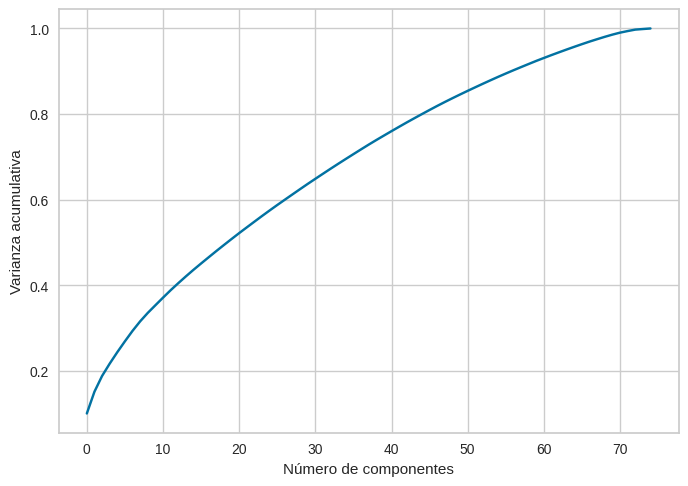

In [ ]:
# Varianza acumulativa para estimar cantidad de componentes principales
pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulativa')
plt.show();

Como la curva es suave, fijamos un límite para tener al menos el 70% de los datos explicados.

In [ ]:
# Retener el 70 % de la varianza
pca = PCA(n_components=0.7).fit(X_scaled)

print("Número de componentes: ",pca.n_components_)

Número de componentes:  36


In [ ]:
# Aplicar PCA con 36 componentes principales
pca = PCA(n_components=36, random_state = 42)

pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

In [ ]:
print("Forma original: {}".format(str(df.shape)))
print("Forma reducida: {}".format(str(X_pca.shape)))

Forma original: (34878, 75)
Forma reducida: (34878, 36)


## Análisis no supervisado

### Algoritmo DBScan

Hacemos un gráfico de "rodilla" o "codo" para poder elegir el parámetro `eps`.

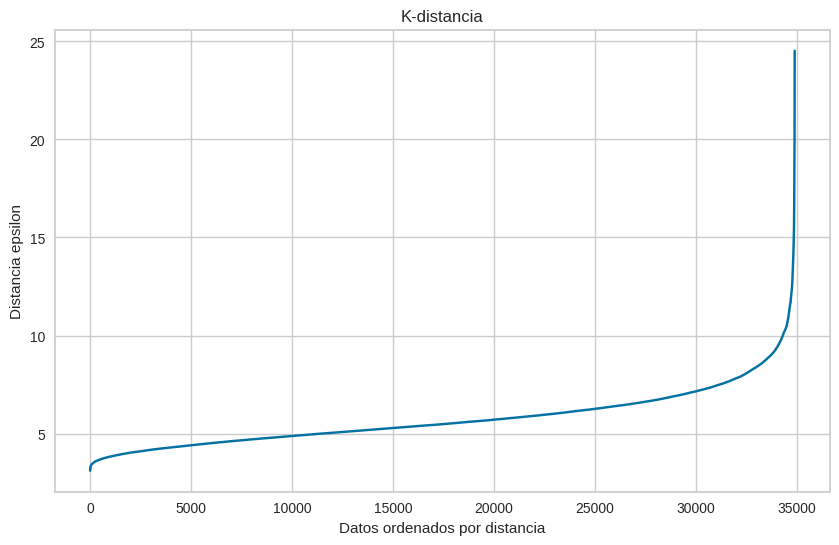

In [ ]:
from sklearn.neighbors import NearestNeighbors

min_samples = 37

# Calcula las distancias a los k vecinos más cercanos
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Ordena las distancias y grafica
distances = np.sort(distances[:, min_samples-1], axis=0)
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.xlabel('Datos ordenados por distancia')
plt.ylabel('Distancia epsilon')
plt.title('K-distancia')
plt.show()


Notamos algo extraño en el gráfico, ya que el codo esta sobre valores de epsilon muy grandes, lo que indica que varios puntos muy distantes serán tomados como parte del mismo clúster. Probaremos de todas maneras con estos valores para evaluar resultados.

In [ ]:
epsilon = 6.9 # Radio de la vecindad en DBSCAN
min_samples = 37  # Número mínimo de muestras en una vecindad para formar un cluster


# Aplicación del algoritmo DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X_pca)  # Ajuste del modelo DBSCAN
labels = db.labels_  # Etiquetas asignadas a cada punto
no_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Número de clusters encontrados (excluyendo ruido)
no_noise = list(labels).count(-1)  # Número de puntos clasificados como ruido (outliers)
print('# Clusters estimados: %d' % no_clusters)  # Muestra el número de clusters estimado
print('# Puntos ruidosos: %d' % no_noise)  # Muestra el número de ruido


# Clusters estimados: 2
# Puntos ruidosos: 2547


Se encontraron dos clústers y pocos puntos de ruido, cerca del 1% de los datos. Intentaremos verlo gráficamente y analizarlo.

In [ ]:
# Función para graficar clústers y ruido

def plot_DBSCAN(X1,labels_1,db_1,n_clusters_1):
    # Creamos una máscara
    core_samples_mask_1 = np.zeros_like(db_1.labels_, dtype=bool)
    # esta función devuelve un array de ceros con la misma forma y tipo que el array de entrada (db_1.labels_)
    core_samples_mask_1[db_1.core_sample_indices_] = True # los elementos de core_sample_indices_ se ponen a True
    # Plot result


    unique_labels = set(labels_1) # crea un conjunto con los elementos de labels_1 (elimina los duplicados) y lo asigna a unique_labels (etiquetas únicas)
    colors = [plt.cm.Spectral(each) # crea una lista de colores (cada color es una lista de 4 elementos) con la paleta Spectral (cmap)
              for each in np.linspace(0, 1, len(unique_labels))] # np.linspace devuelve números espaciados uniformemente sobre un intervalo especificado (0,1) y len(unique_labels) es el número de elementos que devuelve linspace (número de etiquetas únicas)
    for k, col in zip(unique_labels, colors): # zip crea una lista de tuplas, cada tupla contiene un elemento de unique_labels y un elemento de colors (cada color es una lista de 4 elementos)
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels_1 == k) # crea una máscara con los elementos de labels_1 que son iguales a k (etiquetas únicas) y lo asigna a class_member_mask (máscara de miembros de clase)

        xy = X1[class_member_mask & core_samples_mask_1] # crea un array con los elementos de X1 que cumplen las dos condiciones (class_member_mask y core_samples_mask_1) y lo asigna a xy
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14) # pinta los puntos de xy (coordenada x y coordenada y) con el color de la paleta Spectral (col) y con un tamaño de 14 (markersize)

        xy = X1[class_member_mask & ~core_samples_mask_1] # crea un array con los elementos de X1 que cumplen la primera condición (class_member_mask) y no cumplen la segunda (core_samples_mask_1) y lo asigna a xy
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6) # pinta los puntos de xy (coordenada x y coordenada y) con el color de la paleta Spectral (col) y con un tamaño de 6 (markersize)
    plt.title('Número estimado de clusters: %d' % n_clusters_1, fontsize = 15) # pone un título al gráfico con el número de clusters estimado (n_clusters_1)
    plt.show()
    return

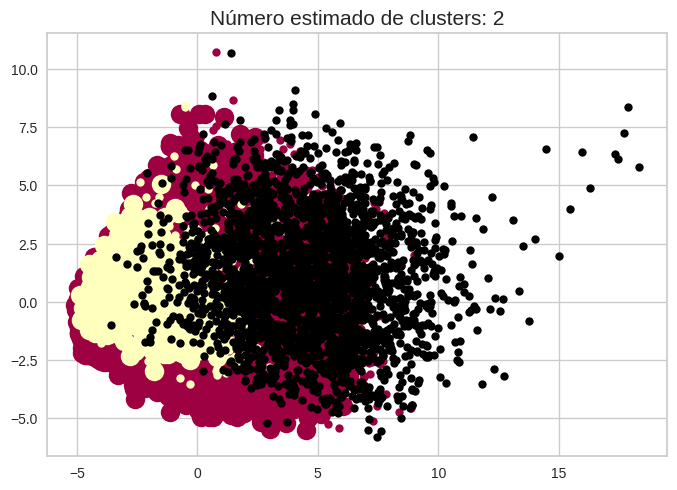

In [ ]:
plot_DBSCAN(X_pca, labels, db, no_clusters)

Como estos resultados no nos parecen apropiados, haremos iteraciones con distintos valores de eps y min_samples

In [ ]:
# Rango posible de clústeres en el que se encuentra la rodilla
eps_values = np.arange(5,7,0.25)

# Rango en el que se encuentra el número de features que obtienen la mayor varianza acumulada
min_samples = [5, 10, 20, 40, 50, 100]

from itertools import product
dbscan_paramns = list(product(eps_values, min_samples)) # Lista de combinatoria cruzada
n_of_clusters = []
sil_score = []
for p in dbscan_paramns:
    y_dbscan = DBSCAN(eps = p[0], min_samples = p[1]).fit_predict(X_pca)
    try:
        sil_score.append(silhouette_score(X_pca, y_dbscan))
    except:
        sil_score.append(0)
    n_of_clusters.append(len(np.unique(y_dbscan)))

data_paramns_tunning = pd.DataFrame.from_records(dbscan_paramns, columns = ["Eps", "Min_samples"])
data_paramns_tunning["sil_score"] = sil_score
data_paramns_tunning["n_clusters"] = n_of_clusters

Haremos dos heatpmap con los resultados, uno comparando la métrica de silhouette y otro la cantidad de clústers encontrados con todas las iteraciones.

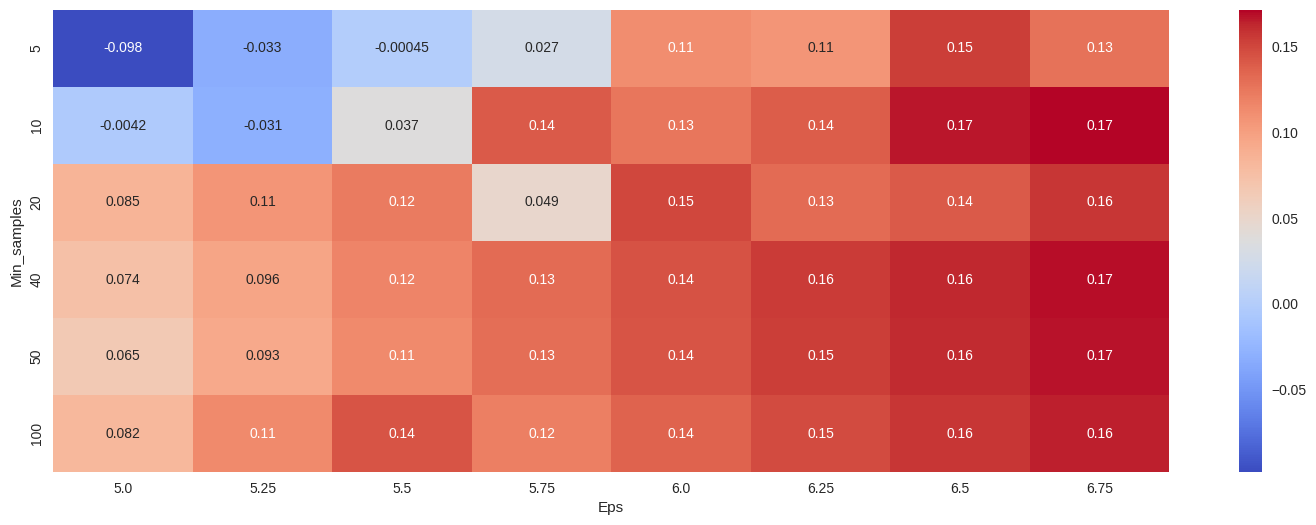

In [ ]:
# Heatmap de la combinación óptima entre el número de muestras y el epsilon
# que maximiza el coeficiente de silueta
pivot_1 = pd.pivot_table(data_paramns_tunning, values = "sil_score", columns = "Eps", index = "Min_samples")
fig, ax = plt.subplots(figsize = (18,6))
sns.heatmap(pivot_1, annot = True, annot_kws = {"size":10}, cmap = "coolwarm", ax = ax)
plt.show()

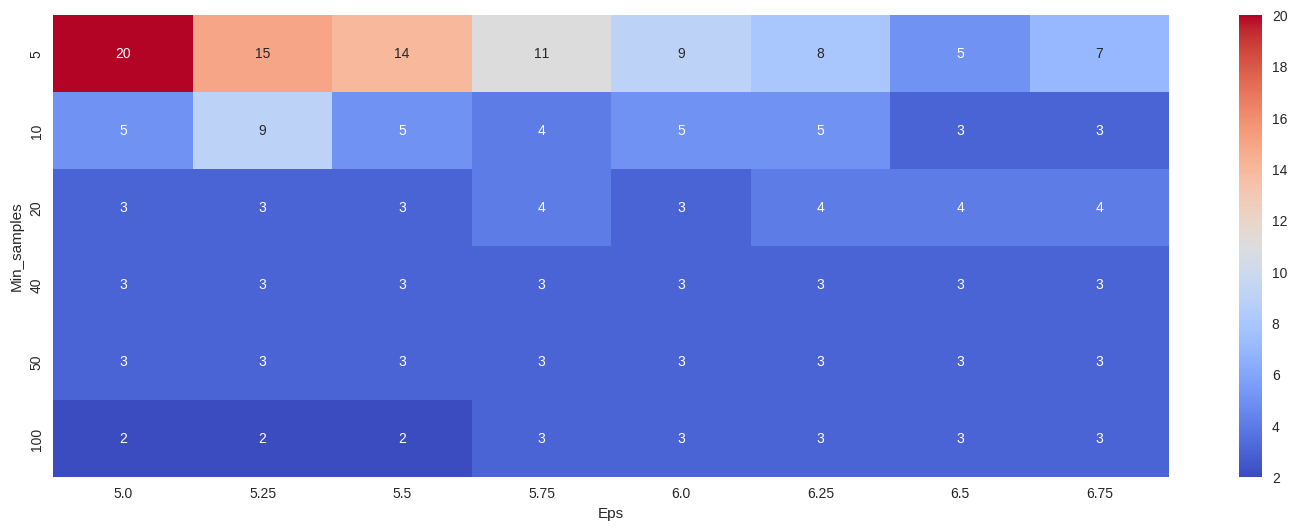

In [ ]:
# Heatmap de la combinación óptima entre el número de muestras y el epsilon
# en función del número de clústeres
pivot_2 = pd.pivot_table(data_paramns_tunning, values = "n_clusters", columns = "Eps", index = "Min_samples")
fig, ax = plt.subplots(figsize = (18,6))
sns.heatmap(pivot_2, annot = True, annot_kws = {"size":10}, cmap = "coolwarm", ax = ax)
plt.show()

Vemos que ninguna combinación da un silhouette score cercano a uno, tomamos la combinación que daría el "mejor" score (0.16) y 4 clústers (siendo uno ruido)

In [ ]:
epsilon = 6.75 # Radio de la vecindad en DBSCAN
min_samples = 20  # Número mínimo de muestras en una vecindad para formar un cluster


# Aplicación del algoritmo DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X_pca)  # Ajuste del modelo DBSCAN
labels = db.labels_  # Etiquetas asignadas a cada punto
no_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Número de clusters encontrados (excluyendo ruido)
no_noise = list(labels).count(-1)  # Número de puntos clasificados como ruido (outliers)
print('# Clusters estimados: %d' % no_clusters)  # Muestra el número de clusters estimado
print('# Puntos ruidosos: %d' % no_noise)  # Muestra el número de ruido


# Clusters estimados: 3
# Puntos ruidosos: 2631


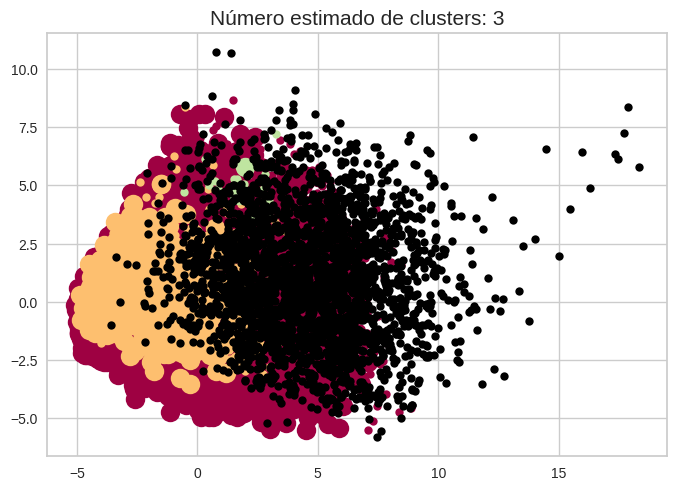

In [ ]:
plot_DBSCAN(X_pca, labels, db, no_clusters)

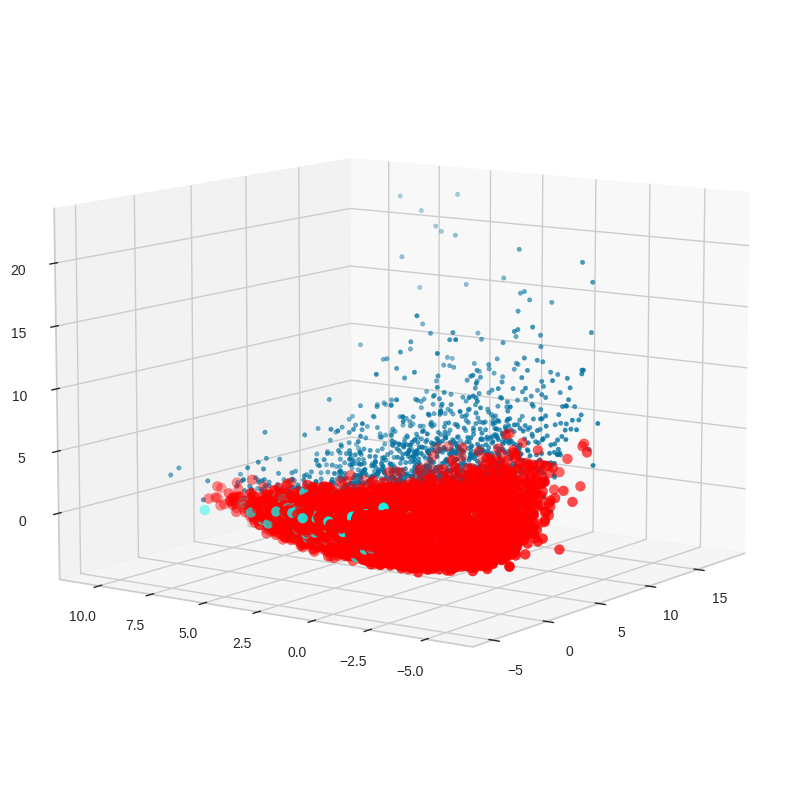

In [ ]:
noise = [values for values, label in zip(X_pca, labels) if label == -1]
noise = np.array(noise)

clusters = [values for values, label in zip(X_pca, labels) if label != -1]
clusters = np.array(clusters)
colors = [label for label in labels if label != -1]

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.scatter3D(noise[:,0], noise[:,1], noise[:,2],  s=10)
ax.scatter3D(clusters[:,0], clusters[:,1], clusters[:,2], s=50, c=colors, cmap='hsv')
ax.view_init( 10, 215)
plt.show()

In [ ]:
#Cantidad de elementos por Clúster
np.asarray(np.unique(labels, return_counts=True)).T

array([[   -1,  2631],
       [    0, 31638],
       [    1,   587],
       [    2,    22]])

Tal como se ve en la gráfica, se formaron tres clústers pero uno contiene al 90% de los datos y hay más ruido que datos en los otros dos clústers. Evidentemente no es una buena agrupación.

Probamos ahora con epsilon más pequeños y varias iteraciones para analizar si hay alguna combinación mejor.

In [ ]:
# Rango posible de clústeres en el que se encuentra la rodilla
eps_values = np.arange(0.05,2,0.15)

# Rango en el que se encuentra el número de features que obtienen la mayor varianza acumulada
min_samples = [5, 10, 20, 40, 50, 100]

from itertools import product
dbscan_paramns = list(product(eps_values, min_samples)) # Lista de combinatoria cruzada
n_of_clusters = []
sil_score = []
for p in dbscan_paramns:
    y_dbscan = DBSCAN(eps = p[0], min_samples = p[1]).fit_predict(X_pca)
    try:
        sil_score.append(silhouette_score(X_pca, y_dbscan))
    except:
        sil_score.append(0)
    n_of_clusters.append(len(np.unique(y_dbscan)))

data_paramns_tunning = pd.DataFrame.from_records(dbscan_paramns, columns = ["Eps", "Min_samples"])
data_paramns_tunning["sil_score"] = sil_score
data_paramns_tunning["n_clusters"] = n_of_clusters

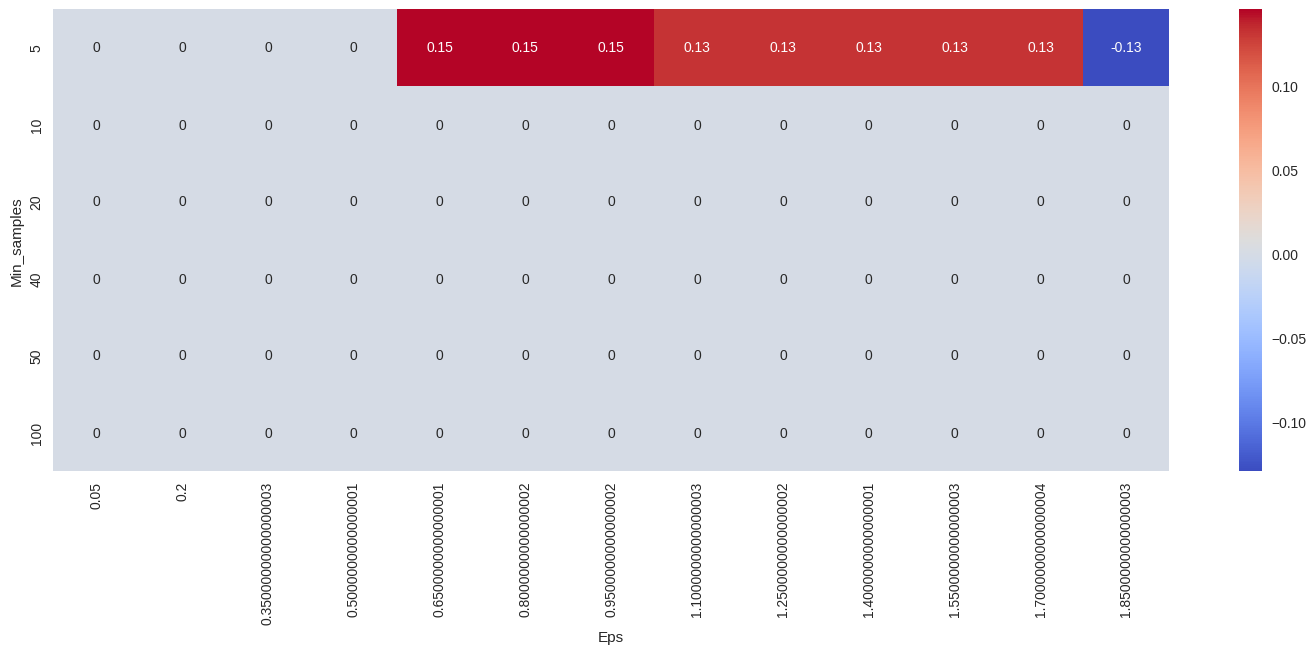

In [ ]:
# Heatmap de la combinación óptima entre el número de muestras y el epsilon
# que maximiza el coeficiente de silueta
pivot_1 = pd.pivot_table(data_paramns_tunning, values = "sil_score", columns = "Eps", index = "Min_samples")
fig, ax = plt.subplots(figsize = (18,6))
sns.heatmap(pivot_1, annot = True, annot_kws = {"size":10}, cmap = "coolwarm", ax = ax)
plt.show()

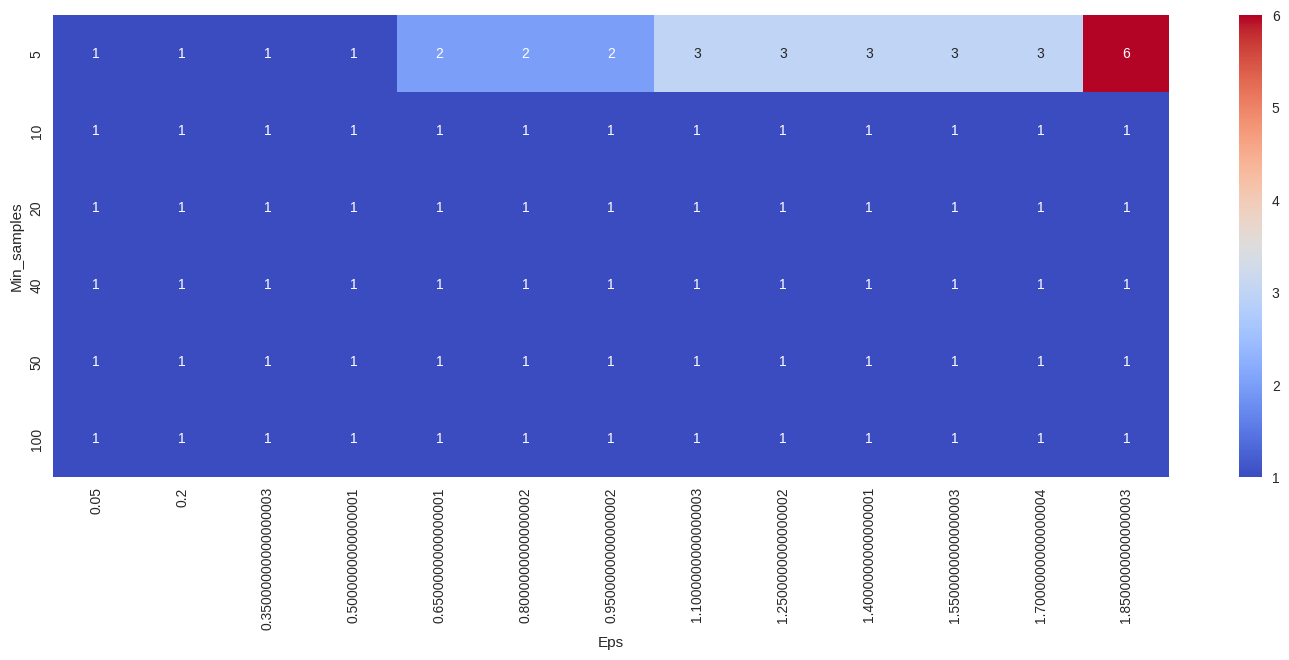

In [ ]:
# Heatmap de la combinación óptima entre el número de muestras y el epsilon
# en función del número de clústeres
pivot_2 = pd.pivot_table(data_paramns_tunning, values = "n_clusters", columns = "Eps", index = "Min_samples")
fig, ax = plt.subplots(figsize = (18,6))
sns.heatmap(pivot_2, annot = True, annot_kws = {"size":10}, cmap = "coolwarm", ax = ax)
plt.show()

Tampoco hay buenas métricas de silhouette con estos parámetros. Probamos con la mejor combinación posible con un silhouette score de 0.13 y 3 clústers (siendo uno de ellos ruido)

In [ ]:
epsilon = 1.1 # Radio de la vecindad en DBSCAN
min_samples = 5  # Número mínimo de muestras en una vecindad para formar un cluster


# Aplicación del algoritmo DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X_pca)  # Ajuste del modelo DBSCAN
labels = db.labels_  # Etiquetas asignadas a cada punto
no_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Número de clusters encontrados (excluyendo ruido)
no_noise = list(labels).count(-1)  # Número de puntos clasificados como ruido (outliers)
print('# Clusters estimados: %d' % no_clusters)  # Muestra el número de clusters estimado
print('# Puntos ruidosos: %d' % no_noise)  # Muestra el número de ruido
#Cantidad de elementos por Clúster
print(f"Distribución de los clústers:\n {np.asarray(np.unique(labels, return_counts=True)).T}")

# Clusters estimados: 2
# Puntos ruidosos: 34868
Distribución de los clústers:
 [[   -1 34868]
 [    0     5]
 [    1     5]]


Vemos que arma dos clústers de solo 5 integrantes y todo el resto de los datos son ruido

## Conclusiones

**Este modelo no es adecuado** en este caso porque los parámetros elegidos no logran una buena separación de los datos en clústeres significativos.

Con un epsilon de 6.75 y min_samples de 20, se genera un clúster dominante que agrupa el 90% de los datos, mientras que los otros dos clústeres son prácticamente insignificantes y con un alto nivel de ruido, lo que indica una agrupación poco informativa.

Por otro lado, con un epsilon de 1.1 y min_samples de 5, se crean dos pequeños clústeres con solo 5 elementos cada uno, mientras que el resto de los datos es clasificado como ruido. Esto muestra que los parámetros están demasiado ajustados, lo que impide la formación de clústeres relevantes y resulta en una pérdida de información valiosa.

En resumen, DBSCAN no es efectivo con estos parámetros porque o bien agrupa demasiados puntos juntos en un solo clúster dominante o bien clasifica la mayoría de los datos como ruido, lo que no cumple con los objetivos de una buena agrupación.